<a href="https://colab.research.google.com/github/dyvanoff/CaroBarato/blob/master/CarooBarato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

El presente analisis se realiza sobre un conjunto de datos normalizados de precios, sucursales y productos derivado de datos 
obtenidos de la página de Precios Claros (http://preciosclaros.gob.ar/). 

En las siguientes secciones se procedera a presentar la información del conjunto de datos. Identificaremos las variables 
más relevantes, sus relaciones y elaboraremos una conclusión al respecto.

# Presentación del Conjunto de Datos

In [ ]:
%pylab inline
import pandas as pd
from io import StringIO
import numpy as np
import seaborn as sns
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

sns.set(style='ticks', color_codes=True)
sns.set_context(context='talk', font_scale=1.2)

from google.colab import files

# Install Kaggle library
!pip install -q kaggle

#Definimos colores
BLUE = '#35A7FF'
RED = '#FF5964'


Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Upload kaggle API key file only first time
#uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
#move kaggle.json API KEY file 
#!mv kaggle.json /root/.kaggle

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
#change permission kaggle.json API KEY file
#!chmod 600 /root/.kaggle/kaggle.json

In [28]:
#!donwload dataset zip file to colab
#!kaggle datasets download -d darioyvanoff/preciosucursalproducto

 54% 17.0M/31.2M [00:02<00:02, 5.58MB/s]
100% 31.2M/31.2M [00:02<00:00, 12.2MB/s]


In [33]:
#read dataset zip file
file_name =  'preciosucursalproducto.zip'
precio_sucursal_producto = pd.read_pickle(file_name)

In [34]:
precio_sucursal_producto.dtypes

precio                 float64
producto_id             object
sucursal_id             object
fecha                   object
marca                   object
nombre                  object
presentacion            object
categoria1              object
categoria2              object
categoria3              object
comercioId             float64
banderaId              float64
banderaDescripcion      object
comercioRazonSocial     object
provincia               object
localidad               object
direccion               object
lat                    float64
lng                    float64
sucursalNombre          object
sucursalTipo            object
nom_provincia           object
region                  object
cantidad               float64
unidad                  object
nombre_sin_um           object
dtype: object

In [35]:
precio_sucursal_producto.describe(include='all')

,precio,producto_id,sucursal_id,fecha,marca,nombre,presentacion,categoria1,categoria2,categoria3,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo,nom_provincia,region,cantidad,unidad,nombre_sin_um
count,2.214788e+06,2222411,2222411,2222411,2222411,2222411,2222411,5,5,5,2.202411e+06,2.202411e+06,2202411,2202411,2202411,2202411,2202411,2.202411e+06,2.202411e+06,2202411,2202411,2202411,2202411,2.222411e+06,2222411,2222411
unique,NaN,71716,513,5,5644,63660,1168,2,2,2,NaN,NaN,45,34,24,309,491,NaN,NaN,464,4,24,4,NaN,7,58270
top,NaN,7793100111563,49-1-2,20200426,SIN MARCA,Edulcorante Liquido Hileret Zucra 200 Cc,1.0 kg,Perfumería y Cuidado Personal,Cuidado Capilar,Acondicionadores,NaN,NaN,Hipermercado Carrefour,INC S.A.,AR-B,LA PLATA,Av. 25 De Mayo Y Garmendia 0,NaN,NaN,Super TUTI 3,Supermercado,Provincia de Buenos Aires,Centro,NaN,gr,Gaseosa Sprite
freq,NaN,545,75516,478909,64702,723,109079,4,4,4,NaN,NaN,339572,556040,772902,161996,75516,NaN,NaN,75516,1098206,772902,1207678,NaN,946281,1379
mean,1.856890e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.652007e+01,1.605383e+00,NaN,NaN,NaN,NaN,NaN,-3.454504e+01,-6.285409e+01,NaN,NaN,NaN,NaN,2.411996e+02,NaN,NaN
std,3.627684e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.432286e+01,1.096062e+00,NaN,NaN,NaN,NaN,NaN,6.110636e+00,4.054112e+00,NaN,NaN,NaN,NaN,2.571440e+02,NaN,NaN
min,1.200000e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,-5.481010e+01,-7.221356e+01,NaN,NaN,NaN,NaN,8.000000e-01,NaN,NaN
25%,6.690000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,-3.660429e+01,-6.545231e+01,NaN,NaN,NaN,NaN,1.600000e+01,NaN,NaN
50%,1.189500e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+01,1.000000e+00,NaN,NaN,NaN,NaN,NaN,-3.459195e+01,-6.289345e+01,NaN,NaN,NaN,NaN,1.500000e+02,NaN,NaN
75%,2.140000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.600000e+01,2.000000e+00,NaN,NaN,NaN,NaN,NaN,-3.155759e+01,-5.862642e+01,NaN,NaN,NaN,NaN,4.000000e+02,NaN,NaN


# Variables de interés

Basado en que el objetivo final de este proyecto es encontrar una forma de identificar si un producto está caro o barato, no en una sucursal puntual, sino dada una región o ciudad hemos decidido como variables relevantes:
- producto_id/nombre_sin_um: identifican a un producto y son variables categóricas nominales.
- localidad, provincia,region: que especifican la ubicación de la tienda y que son variables categóricas nominales.
- comercioRazonSocial: variable categórica nominal.
- fecha: variable cuantitativa
- precio: variable cuantitativa continua.

In [ ]:
precio_sucursal_producto.shape

(2222411, 26)

In [ ]:
precio_sucursal_producto.isna().sum()

precio                    7623
producto_id                  0
sucursal_id                  0
fecha                        0
marca                        0
nombre                       0
presentacion                 0
categoria1             2222406
categoria2             2222406
categoria3             2222406
comercioId               20000
banderaId                20000
banderaDescripcion       20000
comercioRazonSocial      20000
provincia                20000
localidad                20000
direccion                20000
lat                      20000
lng                      20000
sucursalNombre           20000
sucursalTipo             20000
nom_provincia            20000
region                   20000
cantidad                     0
unidad                       0
nombre_sin_um                0
dtype: int64

Como se observa en las variables de interes seleccionadas se encuentran 7623 NaN en la variable precio mientras que se ecuentran  20000 NaN en comercioRazonSocial, provincia y localidad.

**Importante:** Habida cuenta que las 7623 filas de precios NaN representan solo el 0.34% de los datos decidimos eliminarlos de nuestro conjunto de datos.

Generamos un dataset solo con las variables relevantes identificadas que se utilizará para las siguientes secciones de análisis

In [ ]:
#Generamos un dataset con las variables de interes sin NaN en precios y convirtiendo la fecha a int64 para mejor tratamiento posterior
precio_no_nan=~precio_sucursal_producto.precio.isna()
dataset = precio_sucursal_producto[precio_no_nan]
datasetNew=dataset[['fecha','sucursal_id','producto_id','nombre_sin_um','localidad','nom_provincia','region','comercioRazonSocial','presentacion','precio']]
datasetNew=datasetNew.astype({'fecha': 'int64'})
datasetNew.shape

(2214788, 10)

**Nota:** Luego de eliminar los NaN en la columna precio del dataset original obtenemos un conjunto de datos con 7623 filas menos ( 2222411 - 2214788) en nuestro conjunto de datos.

In [ ]:
datasetNew.localidad.isna().sum()

17998

**REVISAR verificar si podemos inferir de alguna manera los valores de sucursal desde los datos**

**Quedan 17998 filas NaN en localidad CONSULTAR RECOMENDACIONES** 

In [ ]:
datasetNew.sample(5)

,fecha,sucursal_id,producto_id,nombre_sin_um,localidad,nom_provincia,region,comercioRazonSocial,precio
2154345,20200518,2-1-134,7798024399905,Helado Chocolate Frutilla Vainilla Dulce de Le...,Trelew,Chubut,Patagonia,S.A. Importadora y Exportadora de la Patagonia,665.00
1517015,20200502,9-3-5222,7790170914759,Te en Saquitos Rapida Infusion La Morenita,GODOY CRUZ,Mendoza,Cuyo,Jumbo Retail Argentina S.A.,33.76
208423,20200412,46-1-3,7790895009853,Jugo Listo Manzana Cepita,LA PLATA,Provincia de Buenos Aires,Centro,Almacenes de Marca S.A.,71.50
233353,20200412,13-1-119,7791130962476,Limpiador Liquido Vainilla Procenex,San Martín de los Andes,Neuquén,Patagonia,Cooperativa Obrera Limitada de Consumo y Vivienda,90.00
1819834,20200518,10-2-216,10-2-2303914000004,Copos de Maiz sin Azucar,Vicente López,Provincia de Buenos Aires,Centro,INC S.A.,317.00


# Estadísticos

Comenzamos mostrando los valores estadisticos de media, mediana, desvios entre otros de las variables de interes en el conjunto de datos

In [ ]:
datasetNew.describe(include='all')

,fecha,producto_id,nombre_sin_um,localidad,provincia,region,comercioRazonSocial,precio
count,2.214788e+06,2214788,2214788,2196790,2196790,2196790,2196790,2.214788e+06
unique,NaN,71354,57989,306,24,4,33,NaN
top,NaN,7793100111563,Gaseosa Sprite,LA PLATA,AR-B,Centro,INC S.A.,NaN
freq,NaN,545,1379,161996,767427,1202057,556040,NaN
mean,2.020045e+07,NaN,NaN,NaN,NaN,NaN,NaN,1.856890e+02
std,4.438824e+01,NaN,NaN,NaN,NaN,NaN,NaN,3.627684e+02
min,2.020041e+07,NaN,NaN,NaN,NaN,NaN,NaN,1.200000e-01
25%,2.020042e+07,NaN,NaN,NaN,NaN,NaN,NaN,6.690000e+01
50%,2.020043e+07,NaN,NaN,NaN,NaN,NaN,NaN,1.189500e+02
75%,2.020050e+07,NaN,NaN,NaN,NaN,NaN,NaN,2.140000e+02


**a- Outliers de variables seleccionadas**

En esta sección se verificará la existencia de outliers en las variables seleccionadas. Para ello en primera medida se procedera a realizar representaciones gráficas a través de boxplot de manera de poder identificarlos.

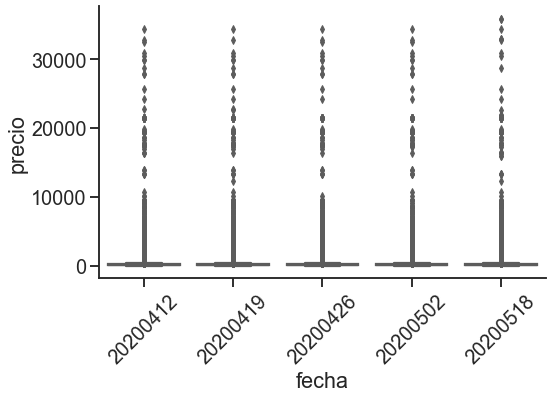

In [ ]:
plt.figure(figsize=(8,5))
p1=sns.boxplot(data=datasetNew, color=BLUE,
                x='fecha', y='precio')
plt.ylabel('precio')
plt.xlabel('fecha')
plt.xticks(rotation=45)
sns.despine()

**REVISAR armar un dataset con media y desvios de cada producto a nivel nacional y obtener un dataset con todos los outliers que esten a mas de 3 desvios standares para cada fecha del conjunto de datos**

Para detectar los outliers decidimos utilizar la función *clean_outliers* (implementada abajo). La misma define como outliers a las realizaciones de los datos cuyo valor cumple que **(x > 1.5**$\times$**IQR + Q3)** o **(x < 1.5**$\times$**IQR - Q1)**, donde **IQR=Q3-Q1**.

In [ ]:
#Función para remover outliers más allá de whis*(Q3-Q1).
def clean_outliers(dataset, column_name, whis=1.5):
    """Returns dataset removing the outlier rows from column @column_name."""
    interesting_col = dataset[column_name]
    # Here we can remove the outliers from both ends, or even add more restrictions.
    Q1 = np.quantile(interesting_col, 0.25, interpolation='midpoint')
    Q3 = np.quantile(interesting_col, 0.75, interpolation='midpoint')
    mask_variable_outlier = ((interesting_col <= Q3 + whis*(Q3-Q1))
                            &
                             (Q1 - whis*(Q3-Q1) <= interesting_col))
    return dataset[mask_variable_outlier]

A continuación se muestra el número de outliers de **Precio** en todos los dias informados en el conjunto de datos por un lado, y luego por separado dia por dia por el otro. 

In [ ]:
#Vemos cuántos outliers presentan precio juntando todos los dias
Out_Glo_precio = len(datasetNew) - len(clean_outliers(datasetNew, 'precio'))
print('Todos los dias juntos'
      '\n Outliers de precio: %2i == %2.2f %% del total'
    %(Out_Glo_precio, Out_Glo_precio*100/float(len(datasetNew))))
print('')

#Un vistazo a la cantidad de outliers por dia
for i in datasetNew.fecha.unique():
    dia = (datasetNew.fecha == i)
    Out_Glo_precio_dia = len(datasetNew[dia]) - len(clean_outliers(datasetNew[dia],'precio'))
    print('Día %i'
          '\n Outliers de precio: %2i == %2.2f %% del total'
          %(i,
            Out_Glo_precio_dia, Out_Glo_precio_dia*100/float(len(datasetNew[dia]))))

Todos los dias juntos
 Outliers de precio: 170577 == 7.70 % del total

Día 20200412
 Outliers de precio: 37028 == 7.84 % del total
Día 20200419
 Outliers de precio: 34849 == 7.63 % del total
Día 20200426
 Outliers de precio: 36418 == 7.63 % del total
Día 20200502
 Outliers de precio: 30286 == 7.66 % del total
Día 20200518
 Outliers de precio: 31577 == 7.64 % del total


**b- Dstribuciones de las variables de interés**

**REVISAR hacer un grafico por fecha y tomar por rango de precios**

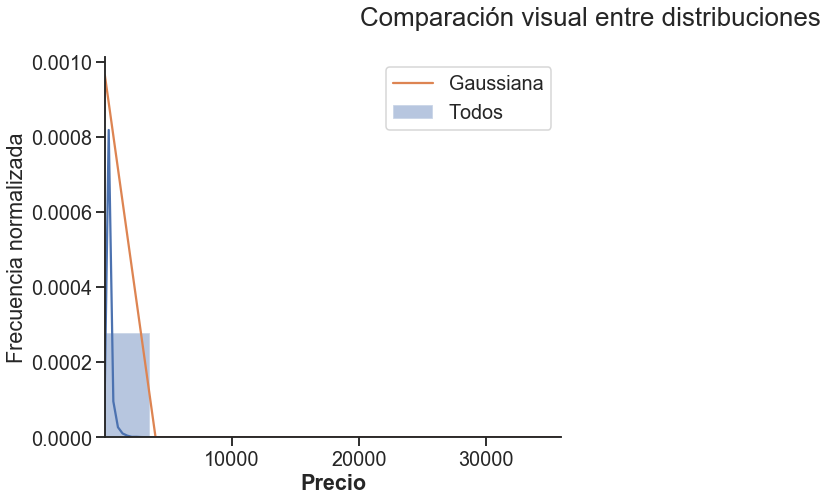

In [ ]:
#Ploteamos para comparar visualmente
bins_pf=10  #Bines para precio

plt.figure(figsize=(18,7))
plt.suptitle('Comparación visual entre distribuciones')

plt.subplot(1,2,1)
sns.distplot(datasetNew.precio, kde=True, norm_hist=True, bins=bins_pf, label='Todos')
sns.lineplot(np.linspace(min(datasetNew.precio), max(datasetNew.precio), bins_pf),
             sp.stats.norm.pdf(np.linspace(min(datasetNew.precio), max(datasetNew.precio), bins_pf),
                               datasetNew.precio.mean(), datasetNew.precio.std()), label='Gaussiana')

plt.xlabel('Precio', weight='bold')
plt.ylabel('Frecuencia normalizada')
plt.xlim(min(datasetNew.precio), max(datasetNew.precio))
sns.despine()

plt.show()

In [ ]:
#Planteamos la primer hipótesis nula
print('Hipótesis nula: La distribución de Precios es Gaussiana con: '
      '\n mu    = %.3f'
      '\n sigma = %.3f'
      %(datasetNew.precio.mean(), datasetNew.precio.std())), print('')

#Para realizar el ks_test, se normalizan los datos: (x-mu)/sigma), para luego comparar con una distribución normal.
precio_LAC_normed = (datasetNew.precio - datasetNew.precio.mean())/datasetNew.precio.std()

#Nivel de significancia
alpha_hf = 0.05
print('Definimos un nivel de significancia:'
      '\n alpha =', alpha_hf), print('')

#Realizamos el ks_test
_, pvalue_hf = sp.stats.kstest(precio_LAC_normed, 'norm')
print('Realizamos el estadístico de prueba ks_test:'
     '\n pvalue = %f' %pvalue_hf), print('')

#Vemos los resultados
if (alpha_hf>pvalue_hf):
    print('Se rechaza la hipótesis nula con el nivel de significancia impuesto.')
else:
    print('No se puede rechazar la hipótesis nula con el nivel de significancia impuesto.') 

Hipótesis nula: La distribución de Precios es Gaussiana con: 
 mu    = 185.689
 sigma = 362.768

Definimos un nivel de significancia:
 alpha = 0.05

Realizamos el estadístico de prueba ks_test:
 pvalue = 0.000000

Se rechaza la hipótesis nula con el nivel de significancia impuesto.


**Nota:** Basados en el test de Kolmogorov antes realizado podes concluir que los precios no tienen una distribución gausiana. 

**c- Frecuencia de variables categóricas de interés**

Generamos la tabla de Frecuencia de las variables de interés

In [ ]:
datasetNew.describe(exclude=[np.number])

,producto_id,nombre_sin_um,localidad,provincia,region,comercioRazonSocial
count,2214788,2214788,2196790,2196790,2196790,2196790
unique,71354,57989,306,24,4,33
top,7793100111563,Gaseosa Sprite,LA PLATA,AR-B,Centro,INC S.A.
freq,545,1379,161996,767427,1202057,556040


In [ ]:
pd.value_counts(datasetNew['region'])

Centro          1202057
Norte Grande     412417
Patagonia        400122
Cuyo             182194
Name: region, dtype: int64

In [ ]:
pd.value_counts(datasetNew['nombre_sin_um'])

Gaseosa Sprite                                  1379
Cacao en Polvo Instantaneo Nesquik              1278
Coca Cola                                       1272
Shampoo Ceramidas Sedal                         1271
Agua Mineral sin Gas Villavicencio              1246
                                                ... 
Pure de Tomate Sabor Ajo Jettro                    1
Almohaditas Rellenas con Chocolate Chocolino       1
Caramelos Miel y Menta Arcor                       1
Polvo Limpiador Brillador Ode                      1
Jabon Antibacterial Limpieza Profunda Protex       1
Name: nombre_sin_um, Length: 57989, dtype: int64

In [ ]:
pd.value_counts(datasetNew['nom_provincia'])

Provincia de Buenos Aires          767427
Córdoba                            174414
Neuquén                            126637
Salta                              111214
Santa Fe                            96423
Mendoza                             94500
Río Negro                           94496
Tucumán                             89773
Santa Cruz                          70159
Ciudad Autónoma de Buenos Aires     66896
Chubut                              64386
San Luis                            58472
Entre Ríos                          58318
Corrientes                          47230
Jujuy                               45877
Tierra del Fuego                    44444
La Pampa                            38579
Catamarca                           35495
Misiones                            31423
San Juan                            21354
Chaco                               20105
Formosa                             18181
Santiago del Estero                 13119
La Rioja                          

Relaciones interesantes entre variables - Principales conclusiones y posibilidad de futuros aportes

**REVISAR contar el count distinct de las sucursales por provincia**

In [ ]:
pd.value_counts(datasetNew['comercioRazonSocial'])

INC S.A.                                                                                 556040
Jumbo Retail Argentina S.A.                                                              251254
Wal Mart Argentina S.R.L.                                                                223040
S.A. Importadora y Exportadora de la Patagonia                                           182213
Libertad S.A                                                                             118502
Coto Centro Integral de Comercialización S.A.                                             91029
Alberdi S.A.                                                                              85356
ARNALDO P. APPELLA S.A.                                                                   75516
SUPERMERCADO TUTI 2 S.A.                                                                  75513
Autoservicio La Amistad Cooperativa de Trabajo Limitada                                   69276
Cooperativa Obrera Limitada de Consumo y

**d- Distribución de precios condicionada a variables categóricas**

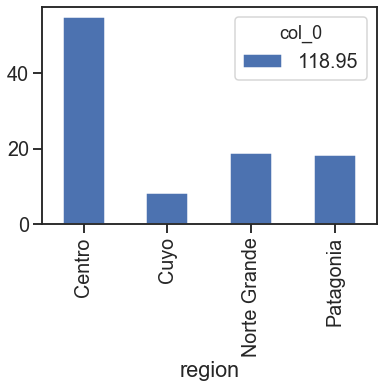

In [ ]:
plot = pd.crosstab(index=datasetNew['region'],
            columns=datasetNew['precio'].median()
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True)

**REVISAR agregar grafica por fecha**

**d- distribución de variables condicionadas**

<Figure size 720x432 with 0 Axes>

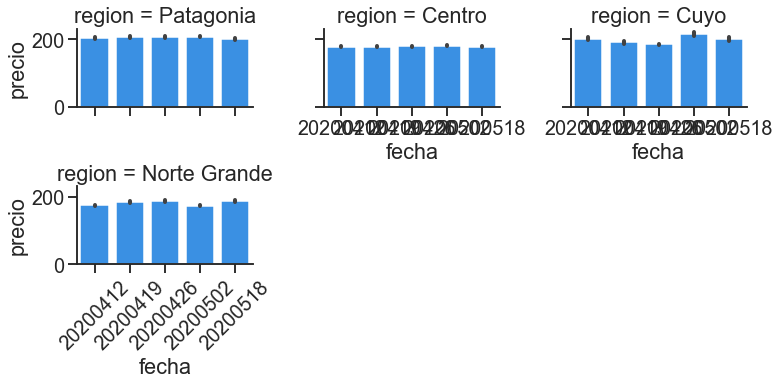

In [ ]:
plt.figure(figsize=(10,6))
g = sns.catplot(x="fecha", y="precio", col="region", col_wrap=3,
                    data=datasetNew, kind="bar", height=2.5, aspect=1.5, color='dodgerblue', margin_titles=False) 
plt.xticks(rotation=45)

plt.show()

**Identificación de un bien númerico**

A fin de poder tener una comparativa de precios relativos procederemos a identificar un producto que se encuentre en todas las regiones 

In [ ]:
pd.Series(datasetNew[datasetNew.nombre_sin_um=='Coca Cola'].region.unique())

0            Cuyo
1          Centro
2    Norte Grande
3       Patagonia
4             NaN
dtype: object

In [ ]:
#datasetNew[(datasetNew.nombre_sin_um=='Coca Cola') & (datasetNew.sucursal_id=='10-1-29')]
datasetNew[(datasetNew.producto_id=='7790895000430') & (datasetNew.region=='Cuyo')]

,fecha,sucursal_id,producto_id,nombre_sin_um,localidad,nom_provincia,region,comercioRazonSocial,presentacion,precio
205183,20200412,10-1-29,7790895000430,Coca Cola,Mendoza,Mendoza,Cuyo,INC S.A.,1.5 lt,100.0
205188,20200412,10-2-286,7790895000430,Coca Cola,Tupungato,Mendoza,Cuyo,INC S.A.,1.5 lt,100.0
205190,20200412,11-2-1015,7790895000430,Coca Cola,MAIPU,Mendoza,Cuyo,Wal Mart Argentina S.R.L.,1.5 lt,100.0
205198,20200412,11-5-3613,7790895000430,Coca Cola,VILLANUEVA,Mendoza,Cuyo,Wal Mart Argentina S.R.L.,1.5 lt,100.0
205200,20200412,12-1-209,7790895000430,Coca Cola,Mendoza,Mendoza,Cuyo,Coto Centro Integral de Comercialización S.A.,1.5 lt,100.0
205208,20200412,16-1-1402,7790895000430,Coca Cola,Godoy Cruz,Mendoza,Cuyo,Libertad S.A,1.5 lt,100.0
205210,20200412,18-1-6,7790895000430,Coca Cola,Juana Koslay,San Luis,Cuyo,Aiello Supermercados S.A.,1.5 lt,100.0
205238,20200412,9-1-868,7790895000430,Coca Cola,SAN RAFAEL,Mendoza,Cuyo,Jumbo Retail Argentina S.A.,1.5 lt,100.0
205242,20200412,9-3-5222,7790895000430,Coca Cola,GODOY CRUZ,Mendoza,Cuyo,Jumbo Retail Argentina S.A.,1.5 lt,100.0
672090,20200419,18-1-5,7790895000430,Coca Cola,San Luis,San Luis,Cuyo,Aiello Supermercados S.A.,1.5 lt,100.0


In [ ]:
bin_numerico=datasetNew[(datasetNew.producto_id=='7790895000430') & (datasetNew.region=='Cuyo')].median()
bien_numerico

100.0

In [ ]:
bien_numerico=datasetNew[(datasetNew['producto_id']=='7790895000430') & (datasetNew.sucursal_id=='10-1-29')].precio.max()
#datasetNew=datasetNew.assign(precio_relativo=datasetNew.precio/bien_numerico)
#datasetNew.sample(5)
bien_numerico

100.0